In [1]:
# ==============================================================
# 0. Imports & global knobs
# ==============================================================
import numpy as np, pandas as pd, torch, time, matplotlib.pyplot as plt
from torch.distributions import Beta
torch.set_default_dtype(torch.double)

N_ASSETS   = 6
R_RATE     = 0.03
N_PATHS_AAD= 60_000          # paths for AAD / pathwise
SEED_BASE  = 42
torch.manual_seed(SEED_BASE)
np.random.seed(SEED_BASE)


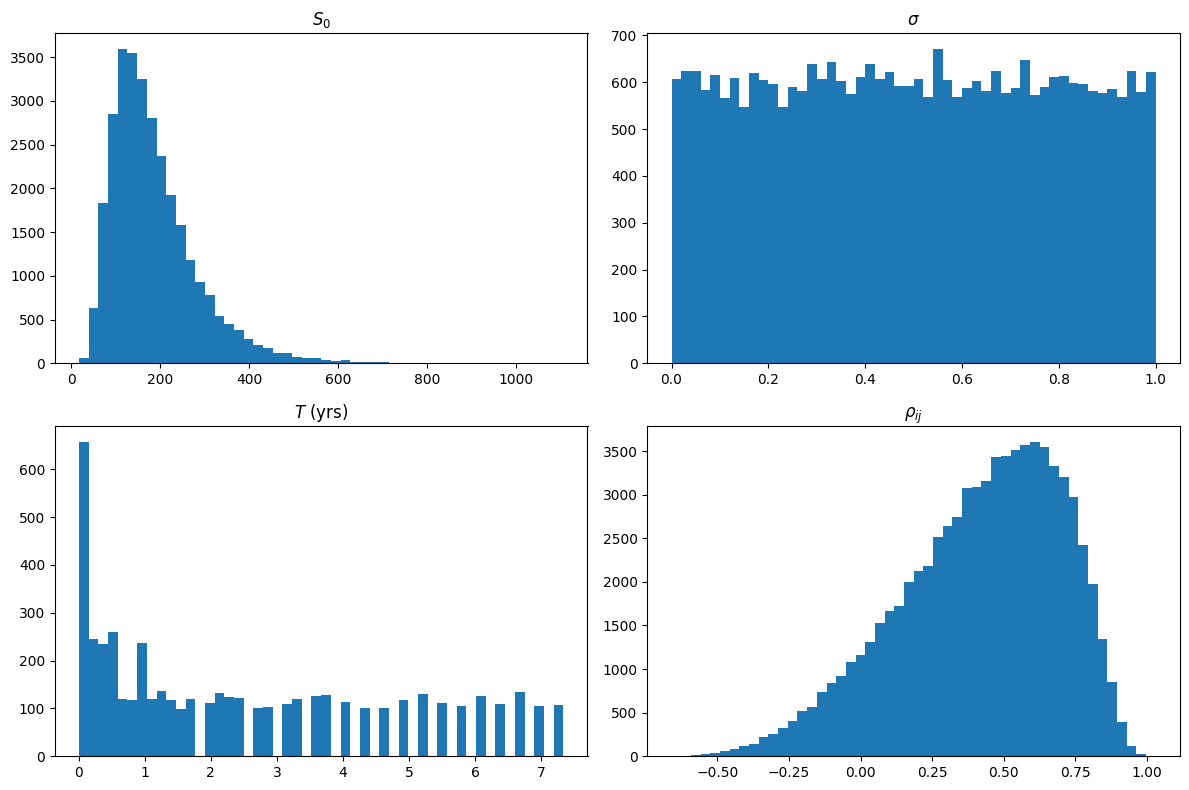

In [2]:

# ==============================================================
# 1. Ferguson-Green sampler  (+ sanity-check plots)
# ==============================================================
def fg_sample(n_assets=N_ASSETS):
    Z      = np.random.normal(0.5, np.sqrt(0.25), n_assets)
    S0     = 100*np.exp(Z)
    sigma  = np.random.uniform(0,1,n_assets)
    X      = np.random.randint(1,44)
    T      = (X**2)/252.0
    beta   = Beta(torch.tensor([5.]), torch.tensor([2.]))
    C      = torch.eye(n_assets, dtype=torch.double)
    for i in range(n_assets):
        for j in range(i+1,n_assets):
            C[i,j] = C[j,i] = 2*beta.sample().item() - 1
    # project to SPD
    ev, evec = torch.linalg.eigh(C)
    C = evec @ torch.diag(torch.clamp(ev, min=1e-4)) @ evec.T
    return dict(S0=S0, sigma=sigma, T=T, rho=C.numpy(), K=100.0)

# --- one-time diagnostic plots (skip when scaling) -------------
if True:
    N_DIAG = 5_000
    S0s,sigs,Ts,rhos=[],[],[],[]
    for _ in range(N_DIAG):
        q = fg_sample()
        S0s.extend(q['S0']); sigs.extend(q['sigma']); Ts.append(q['T'])
        rhos.extend(q['rho'][np.triu_indices(N_ASSETS,1)])
    fig,ax = plt.subplots(2,2,figsize=(12,8))
    ax[0,0].hist(S0s ,50); ax[0,0].set_title('$S_0$')
    ax[0,1].hist(sigs,50); ax[0,1].set_title('$\\sigma$')
    ax[1,0].hist(Ts  ,50); ax[1,0].set_title('$T$ (yrs)')
    ax[1,1].hist(rhos,50); ax[1,1].set_title('$\\rho_{ij}$')
    plt.tight_layout(); plt.show()


In [3]:

# ==============================================================
# 2. Vectorised Monte-Carlo path engine
#    (accepts optional Z for common-random-numbers)
# ==============================================================
def mc_paths(S0, sigma, T, rho, n_paths, n_steps=64, r=R_RATE, Z=None):
    d, dt = S0.numel(), T / n_steps
    chol  = torch.linalg.cholesky(rho)
    if Z is None:
        Z = torch.randn(n_paths, n_steps, d)
    Z = Z @ chol.T
    s = S0.repeat(n_paths, 1)
    drift  = (r - 0.5 * sigma**2) * dt
    vol_dt = sigma * torch.sqrt(dt)
    for t in range(n_steps):
        s = s * torch.exp(drift + vol_dt * Z[:, t, :])
    return s.mean(dim=1)


In [4]:

# ==============================================================
# 3. AAD - first-order Greeks (Δ, ν, ρ, θ) – no Gamma here
# ==============================================================
def greeks_aad(p, n_paths=N_PATHS_AAD):
    S0    = torch.tensor(p['S0'],    requires_grad=True)
    sigma = torch.tensor(p['sigma'], requires_grad=True)
    T     = torch.tensor(p['T'],     requires_grad=True)
    r     = torch.tensor(R_RATE,     requires_grad=True)
    rho_m = torch.tensor(p['rho'])
    K     = p['K']

    basket = mc_paths(S0, sigma, T, rho_m, n_paths, r=r)
    price  = (torch.exp(-r*T) * torch.clamp(basket-K, 0)).mean()

    dS0, dSig, dr, dT = torch.autograd.grad(
        price, (S0, sigma, r, T), create_graph=False
    )

    return dict(price = price.item(),
                delta = dS0.detach().numpy(),
                vega  = dSig.detach().numpy(),
                rho   = dr.item(),
                theta = dT.item())


In [5]:

# ----------------------------------------------------------------
# 3b. Fast diagonal Γ estimator (finite-difference, CRN)
# ----------------------------------------------------------------
def gamma_fd_fast(p, *, n_paths=40_000, n_steps=64, eps=1e-4):
    S0    = torch.tensor(p['S0'])
    sigma = torch.tensor(p['sigma'])
    T     = torch.tensor(p['T'])
    rho_m = torch.tensor(p['rho'])
    K     = p['K']
    r     = R_RATE
    d     = S0.numel()

    n_batch = 1 + 2*d
    S0_mat  = S0.repeat(n_batch, 1)
    for i in range(d):
        h = eps * S0[i]
        S0_mat[1 + 2*i,   i] += h
        S0_mat[1 + 2*i+1, i] -= h

    Z = torch.randn(n_paths, n_steps, d)
    prices = torch.empty(n_batch)

    for j in range(n_batch):
        basket = mc_paths(S0_mat[j], sigma, T, rho_m,
                          n_paths, n_steps, r=r, Z=Z)
        prices[j] = (torch.exp(-r*T) * torch.clamp(basket-K, 0)).mean()

    base  = prices[0].item()
    gamma = torch.empty(d)

    for i in range(d):
        h = eps * S0[i]
        up, dn = prices[1 + 2*i], prices[1 + 2*i + 1]
        gamma[i] = (up - 2*base + dn) / (h*h)

    return gamma.numpy()


In [6]:

# ==============================================================
# 4. Speed & accuracy sanity check (AAD vs FD)
# ==============================================================
p_test = fg_sample()
t0 = time.perf_counter(); g_aad = greeks_aad(p_test); t_aad = time.perf_counter() - t0
t0 = time.perf_counter(); g_gam = gamma_fd_fast(p_test); t_gam = time.perf_counter() - t0

print(f"Price  : {g_aad['price']:.4f}")
print(f"Δ shape: {g_aad['delta'].shape}  | ν shape: {g_aad['vega'].shape}")
print(f"Γ diag : {g_gam}")
print(f"Timing : AAD {t_aad:.2f}s  |  FD-Γ {t_gam:.2f}s")


Price  : 111.6062
Δ shape: (6,)  | ν shape: (6,)
Γ diag : [ 2.97334524e-11  1.97645394e-11  4.74205203e-10  8.52915161e-12
 -7.86148326e-11  5.36994909e-11]
Timing : AAD 0.93s  |  FD-Γ 1.30s


In [7]:

# ==============================================================
# 5. Cohesive dataset generator  (AAD  + FD-Gamma)
# ==============================================================
def generate_dataset(n_rows:int, n_paths:int=50_000, save=None):
    rows = []
    for _ in range(n_rows):
        q = fg_sample()
        g1 = greeks_aad(q, n_paths=n_paths)     # price, Δ, ν, ρ, θ
        g2 = gamma_fd_fast(q, n_paths=n_paths)  # Γ (diagonal)

        rows.append({**{f"S0_{i}":   q['S0'][i]    for i in range(N_ASSETS)},
                     **{f"sigma_{i}":q['sigma'][i] for i in range(N_ASSETS)},
                     "T": q['T'], "price": g1['price'],
                     "rho_greek": g1['rho'], "theta": g1['theta'],
                     **{f"delta_{i}": g1['delta'][i] for i in range(N_ASSETS)},
                     **{f"gamma_{i}": g2[i]          for i in range(N_ASSETS)},
                     **{f"vega_{i}":  g1['vega'][i]  for i in range(N_ASSETS)}})

    df = pd.DataFrame(rows)
    if save:
        df.to_parquet(save) if save.endswith(".parquet") else df.to_csv(save, index=False)
    return df

# Tiny demo (scale rows / paths up later)
df_demo = generate_dataset(100, n_paths=30_000, save="demo.csv")
print("Demo dataset :", df_demo.shape)


Demo dataset : (100, 34)


# Finite Differences Only 

In [50]:
# ==============================================================
# 0. Imports & global knobs (risk‑neutral pricing and full Greeks)
# ==============================================================
import numpy as np, pandas as pd, torch, time, math
from torch.distributions import Beta
from typing import Optional

torch.set_default_dtype(torch.double)

# Model dimensions & Monte Carlo settings
N_ASSETS   = 3            # six underlyings
R_RATE     = 0.03         # constant risk‑free rate for risk‑neutral measure
N_PATHS_MC = 10_000       # inner Monte Carlo paths
SEED_BASE  = 42
EPS_REL    = 1e-4         # relative bump for finite-difference Greeks

# reproducible seeding
torch.manual_seed(SEED_BASE)
np.random.seed(SEED_BASE)

# ==============================================================
# 1. C-vine LKJ correlation generator (paper Appendix B)
# ==============================================================
def cvine_corr(d: int, a: float = 5.0, b: float = 2.0) -> torch.Tensor:
    beta = Beta(torch.tensor([a]), torch.tensor([b]))
    P    = torch.eye(d, dtype=torch.double)
    for k in range(d - 1):
        for i in range(k + 1, d):
            r = 2 * beta.sample().item() - 1.0
            for m in range(k - 1, -1, -1):
                r = r * math.sqrt((1 - P[m, i]**2)*(1 - P[m, k]**2)) + P[m, i]*P[m, k]
            P[k, i] = P[i, k] = r
    ev, evec = torch.linalg.eigh(P)
    return evec @ torch.diag(torch.clamp(ev, min=1e-6)) @ evec.T

# ==============================================================
# 2. Ferguson–Green outer-MC sampler
# ==============================================================
def fg_sample():
    Z     = np.random.normal(0.5, math.sqrt(0.25), N_ASSETS)
    S0    = 100 * np.exp(Z)
    sigma = np.random.uniform(0.0, 1.0, N_ASSETS)
    X     = np.random.randint(1, 44)
    T     = (X**2)/252.0
    rho   = cvine_corr(N_ASSETS).numpy()
    return dict(S0=S0, sigma=sigma, T=T, rho=rho, K=100.0, r=R_RATE)

# ==============================================================
# 3. Vectorised GBM path engine (inner MC, risk-neutral drift)
# ==============================================================
def mc_paths(S0, sigma, T, rho, *,
             n_paths: int = N_PATHS_MC,
             n_steps: int = 64,
             r: float = R_RATE,
             Z: Optional[torch.Tensor] = None):
    # ensure tensor types
    S0, sigma, rho = map(lambda x: torch.as_tensor(x, dtype=torch.double), (S0, sigma, rho))
    dt   = float(T)/n_steps
    chol = torch.linalg.cholesky(rho)
    if Z is None:
        Z = torch.randn(n_paths, n_steps, N_ASSETS, dtype=torch.double)
    Z = Z @ chol.T

    s      = S0.repeat(n_paths, 1)
    drift  = (r - 0.5 * sigma**2) * dt
    vol_dt = sigma * math.sqrt(dt)
    for t in range(n_steps):
        s = s * torch.exp(drift + vol_dt * Z[:, t, :])
    return s                            # (n_paths, N_ASSETS)

# ==============================================================
# 4. Worst-of basket-call price (risk-neutral discount)
# ==============================================================
def price_mc(S0, sigma, T, rho, K, *,
             n_paths: int = N_PATHS_MC,
             n_steps: int = 64,
             r: float = R_RATE,
             Z: Optional[torch.Tensor] = None):
    paths  = mc_paths(S0, sigma, T, rho, n_paths=n_paths, n_steps=n_steps, r=r, Z=Z)
    payoff = torch.clamp(paths.min(dim=1).values - K, 0.0)
    return (math.exp(-r * float(T)) * payoff.mean()).item()

# ==============================================================
# 5. Finite-difference Greeks (Δ, ν, ρ, θ, Γ) — all FD
# ==============================================================
def greeks_fd_full(p: dict, *,
                   n_paths: int = N_PATHS_MC,
                   n_steps: int = 64,
                   eps_rel: float = EPS_REL):
    # unpack parameters
    S0    = torch.tensor(p['S0'], dtype=torch.double)
    sigma = torch.tensor(p['sigma'], dtype=torch.double)
    T     = torch.tensor(p['T'], dtype=torch.double)
    rho_m = torch.tensor(p['rho'], dtype=torch.double)
    K     = p['K']
    r     = p['r']
    d     = S0.numel()

    # fixed CRN seed for all bumps
    Z0    = torch.randn(n_paths, n_steps, d, dtype=torch.double)
    base  = price_mc(S0, sigma, T, rho_m, K, n_paths=n_paths, n_steps=n_steps, r=r, Z=Z0)

    delta = torch.empty(d)
    vega  = torch.empty(d)
    gamma = torch.empty(d)
    eye   = torch.eye(d)

    for i in range(d):
        # Δ & Γ
        hS       = eps_rel * S0[i]
        up       = price_mc(S0 + hS*eye[i], sigma, T, rho_m, K,
                             n_paths=n_paths, n_steps=n_steps, r=r, Z=Z0)
        dn       = price_mc(S0 - hS*eye[i], sigma, T, rho_m, K,
                             n_paths=n_paths, n_steps=n_steps, r=r, Z=Z0)
        delta[i] = (up - dn) / (2*hS)
        gamma[i] = (up - 2*base + dn) / (hS*hS)

        # Vega
        hV       = eps_rel * sigma[i]
        up       = price_mc(S0, sigma + hV*eye[i], T, rho_m, K,
                             n_paths=n_paths, n_steps=n_steps, r=r, Z=Z0)
        dn       = price_mc(S0, sigma - hV*eye[i], T, rho_m, K,
                             n_paths=n_paths, n_steps=n_steps, r=r, Z=Z0)
        vega[i]  = (up - dn) / (2*hV)

    # ρ (rate sensitivity)
    h_r     = eps_rel * abs(r) if abs(r) > 1e-6 else eps_rel
    r_up    = price_mc(S0, sigma, T, rho_m, K,
                       n_paths=n_paths, n_steps=n_steps, r=r+h_r, Z=Z0)
    r_dn    = price_mc(S0, sigma, T, rho_m, K,
                       n_paths=n_paths, n_steps=n_steps, r=r-h_r, Z=Z0)
    rho_g   = (r_up - r_dn) / (2*h_r)

    # θ (time sensitivity)
    hT      = eps_rel * T
    t_up    = price_mc(S0, sigma, T + hT, rho_m, K,
                       n_paths=n_paths, n_steps=n_steps, r=r, Z=Z0)
    t_dn    = price_mc(S0, sigma, torch.clamp(T - hT, min=1e-6), rho_m, K,
                       n_paths=n_paths, n_steps=n_steps, r=r, Z=Z0)
    theta   = (t_up - t_dn) / (2*hT)

    return dict(
        price = base,
        delta = delta.numpy(),
        vega  = vega.numpy(),
        gamma = gamma.numpy(),
        rho   = rho_g,
        theta = theta.item()
    )
# ==============================================================
# 6. Dataset generator (paths-recycling, FD Greeks)
# ==============================================================
def generate_dataset(n_rows: int,
                     *,
                     n_paths: int = N_PATHS_MC,
                     n_steps: int = 64,
                     save: Optional[str] = None):
    rows = []
    for idx in range(n_rows):
        # independent outer-MC seed
        seed_i = SEED_BASE + idx
        np.random.seed(seed_i)
        torch.manual_seed(seed_i)

        q = fg_sample()
        g = greeks_fd_full(q, n_paths=n_paths, n_steps=n_steps)

        row = {**{f"S0_{i}":    q["S0"][i]    for i in range(N_ASSETS)},
               **{f"sigma_{i}": q["sigma"][i] for i in range(N_ASSETS)},
               "T": q["T"], "price": g["price"], "r": q["r"]}
        for i in range(N_ASSETS):
            row[f"delta_{i}"] = g["delta"][i]
            row[f"vega_{i}"]  = g["vega"][i]
            row[f"gamma_{i}"] = g["gamma"][i]
        row["rho_greek"] = g["rho"]
        row["theta"]     = g["theta"]
        rows.append(row)

    df = pd.DataFrame(rows)
    if save:
        if save.endswith(".parquet"):
            df.to_parquet(save)
        else:
            df.to_csv(save, index=False)
    return df

# ==============================================================
if __name__ == '__main__':
    t0      = time.perf_counter()
    df_demo = generate_dataset(100, n_paths=10_000, save=None)
    print(f"Demo shape: {df_demo.shape} | elapsed {time.perf_counter()-t0:.4f}s")


Demo shape: (100, 20) | elapsed 111.5976s


## Checks

In [43]:
C = cvine_corr(6)
assert torch.allclose(C, C.T)
assert (torch.linalg.eigvals(C).real > 0).all()
print("✓ correlation matrix OK")


✓ correlation matrix OK


In [44]:
p      = fg_sample()
paths  = mc_paths(p["S0"], p["sigma"], p["T"], p["rho"],
                  n_paths=200_000, n_steps=128, r=p["r"])

discount = torch.exp(torch.tensor(-p["r"] * p["T"], dtype=torch.double))
print(np.round((discount * paths).mean(0).numpy(), 3))   # discounted E[S_T]
print(np.round(p["S0"], 3))                              # should match


[123.309 126.779 123.887 103.854  44.644 265.136]
[123.314 126.797 123.901 103.869  44.652 265.166]


In [45]:
from scipy.stats import norm

# ----- closed-form Greeks ----------------------------------------------------
def bs_call_all(S,K,T,r,sig):
    d1 = (math.log(S/K) + (r + 0.5*sig**2)*T) / (sig*math.sqrt(T))
    d2 = d1 - sig*math.sqrt(T)
    disc = math.exp(-r*T)

    price = S*norm.cdf(d1) - K*disc*norm.cdf(d2)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S*sig*math.sqrt(T))
    vega  = S*norm.pdf(d1) * math.sqrt(T)
    rho   = K*T*disc*norm.cdf(d2)
    theta = -(S*norm.pdf(d1)*sig)/(2*math.sqrt(T)) - r*K*disc*norm.cdf(d2)
    return price, delta, gamma, vega, rho, theta

# ----- draw one random 1-asset case -----------------------------------------
p1              = fg_sample()
S0, sig         = p1["S0"][0], p1["sigma"][0]
K, T, r         = p1["K"],     p1["T"],      p1["r"]

mc              = greeks_fd_full(
                     dict(S0=[S0], sigma=[sig], T=T,
                          rho=np.eye(1), K=K, r=r),
                     n_paths=400_000)

bs              = bs_call_all(S0,K,T,r,sig)

labels = ["price","delta","gamma","vega","rho","theta"]
print("{:<7}   {:>12}   {:>12}".format("Greek","MC","Black-Scholes"))
for lbl, mc_val, bs_val in zip(labels,
                               [mc["price"], mc["delta"][0],
                                mc["gamma"][0], mc["vega"][0],
                                mc["rho"],      mc["theta"]],
                               bs):
    print(f"{lbl:<7} : {mc_val:12.6f}   {bs_val:12.6f}")


Greek               MC   Black-Scholes
price   :   103.938243     103.855145
delta   :     1.000330       0.999923
gamma   :     0.000011       0.000008
vega    :     0.253591       0.031741
rho     :    25.199776      25.199891
theta   :     3.169145      -3.000822


In [2]:
import pandas as pd


file_path = 'worstof_small.parquet'
df = pd.read_parquet(file_path)

print(f"Dataset shape: {df.shape}")

df.head()

Dataset shape: (10000, 20)


,S0_0,S0_1,S0_2,sigma_0,sigma_1,sigma_2,delta_0,delta_1,delta_2,vega_0,vega_1,vega_2,gamma_0,gamma_1,gamma_2,price,rho,theta,T,r
0,211.352480,153.859221,227.924505,0.156019,0.155995,0.058084,0.139628,0.748297,0.005431,-54.362913,-46.203920,0.869554,-2.319859e-03,-4.376636e-03,2.735509e-11,54.599790,208.642594,-0.682756,2.285714,0.03
1,353.076630,105.906329,134.165746,0.650888,0.056412,0.721999,0.003467,0.254993,0.025564,-3.799747,25.310493,-5.749277,7.124629e-13,-1.900499e-10,0.000000e+00,5.803379,92.342409,0.048385,3.571429,0.03
2,123.313651,126.796734,123.900658,0.524756,0.431945,0.291229,0.116757,0.044906,0.173471,-15.120249,-4.738510,25.866185,0.000000e+00,0.000000e+00,0.000000e+00,22.244270,135.383781,0.407604,7.000000,0.03
3,103.868821,145.423213,151.902160,0.618386,0.382462,0.983231,0.633362,0.000000,0.001445,6.711220,0.000000,-0.087271,8.090002e-02,0.000000e+00,0.000000e+00,6.621728,2.120584,58.674812,0.035714,0.03
4,203.095384,249.985050,142.375881,0.942202,0.563288,0.385417,0.082445,0.027932,0.316770,-24.379791,-7.487241,36.554532,0.000000e+00,-1.137004e-11,-3.505237e-11,35.850710,88.460694,-1.457621,2.682540,0.03


In [3]:
import pandas as pd


file_path = 'test.parquet'
df = pd.read_parquet(file_path)

print(f"Dataset shape: {df.shape}")

df.head()

Dataset shape: (10000, 32)


,S0_0,S0_1,S0_2,sigma_0,sigma_1,sigma_2,delta_0,delta_1,delta_2,delta_se_0,...,gamma_se_1,gamma_se_2,price,price_se,rho,rho_se,theta,theta_se,T,r
0,211.352480,153.859221,227.924505,0.156019,0.155995,0.058084,14.459270,-21.049263,-17.902740,10.070562,...,3084.271417,1406.053066,54.599790,0.297906,-104344.876789,69743.388727,1106.554435,929.663792,2.285714,0.03
1,353.076630,105.906329,134.165746,0.650888,0.056412,0.721999,-1.362424,-0.493427,2.933691,2.500099,...,2649.627049,1656.198498,7.244799,0.120904,-64242.237615,29171.858625,-229.168653,242.839628,3.571429,0.03
2,123.313651,126.796734,123.900658,0.524756,0.431945,0.291229,62.035958,-55.049424,24.265721,51.825864,...,11751.878358,12439.474342,23.604639,0.781741,-395967.514683,169351.909852,-661.533721,695.442960,7.000000,0.03
3,103.868821,145.423213,151.902160,0.618386,0.382462,0.983231,-15.120992,9.392068,9.900730,5.738208,...,988.880485,902.644575,6.608305,0.085010,4357.731942,19986.517623,37084.916153,16885.108502,0.035714,0.03
4,203.095384,249.985050,142.375881,0.942202,0.563288,0.385417,-11.316544,5.417212,36.542748,15.467302,...,1928.915238,5812.691280,18.564136,0.506188,-123412.701575,104428.508790,-3548.787478,1198.086449,2.682540,0.03


In [1]:
import pandas as pd


file_path = 'test.parquet'
df2 = pd.read_parquet(file_path)

print(f"Dataset shape: {df2.shape}")

df2.head()

Dataset shape: (10000, 32)


,S0_0,S0_1,S0_2,sigma_0,sigma_1,sigma_2,delta_0,delta_1,delta_2,delta_se_0,...,gamma_se_1,gamma_se_2,price,price_se,rho,rho_se,theta,theta_se,T,r
0,211.352480,153.859221,227.924505,0.156019,0.155995,0.058084,14.459270,-21.049263,-17.902740,10.070562,...,3084.271417,1406.053066,54.599790,0.297906,-104344.876789,69743.388727,1106.554435,929.663792,2.285714,0.03
1,353.076630,105.906329,134.165746,0.650888,0.056412,0.721999,-1.362424,-0.493427,2.933691,2.500099,...,2649.627049,1656.198498,7.244799,0.120904,-64242.237615,29171.858625,-229.168653,242.839628,3.571429,0.03
2,123.313651,126.796734,123.900658,0.524756,0.431945,0.291229,62.035958,-55.049424,24.265721,51.825864,...,11751.878358,12439.474342,23.604639,0.781741,-395967.514683,169351.909852,-661.533721,695.442960,7.000000,0.03
3,103.868821,145.423213,151.902160,0.618386,0.382462,0.983231,-15.120992,9.392068,9.900730,5.738208,...,988.880485,902.644575,6.608305,0.085010,4357.731942,19986.517623,37084.916153,16885.108502,0.035714,0.03
4,203.095384,249.985050,142.375881,0.942202,0.563288,0.385417,-11.316544,5.417212,36.542748,15.467302,...,1928.915238,5812.691280,18.564136,0.506188,-123412.701575,104428.508790,-3548.787478,1198.086449,2.682540,0.03


In [5]:
df.to_csv('results_10M.csv', index=False)

In [4]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
S0_0,10000.0,188.048629,1.009876e+02,2.596785e+01,118.203462,165.278591,233.608109,1.547990e+03
S0_1,10000.0,187.149608,1.009296e+02,2.809921e+01,115.973354,165.205631,231.107960,1.042007e+03
S0_2,10000.0,186.752044,9.891716e+01,1.768020e+01,118.400068,164.736899,230.460118,1.027295e+03
sigma_0,10000.0,0.495064,2.885565e-01,4.812389e-05,0.241591,0.496522,0.743940,9.998714e-01
sigma_1,10000.0,0.500477,2.909251e-01,1.459394e-04,0.250661,0.501513,0.754245,9.998927e-01
sigma_2,10000.0,0.499002,2.885385e-01,5.099890e-04,0.252326,0.494113,0.749814,9.998179e-01
delta_0,10000.0,-0.003580,3.139752e+01,-3.390341e+02,-9.848532,0.000000,9.237411,3.673806e+02
delta_1,10000.0,0.265382,3.565723e+01,-6.936936e+02,-9.428565,0.000000,9.681405,5.713267e+02
delta_2,10000.0,-0.302621,3.258805e+01,-3.790330e+02,-10.164084,0.000000,9.303376,3.381497e+02
delta_se_0,10000.0,14.458940,1.403292e+01,0.000000e+00,5.046846,11.414892,19.264011,1.691130e+02


In [7]:
df2.describe().transpose()  

,count,mean,std,min,25%,50%,75%,max
S0_0,10000.0,188.048629,1.009876e+02,25.967850,1.182035e+02,165.278591,2.336081e+02,1.547990e+03
S0_1,10000.0,187.149608,1.009296e+02,28.099206,1.159734e+02,165.205631,2.311080e+02,1.042007e+03
S0_2,10000.0,186.752044,9.891716e+01,17.680198,1.184001e+02,164.736899,2.304601e+02,1.027295e+03
sigma_0,10000.0,0.495064,2.885565e-01,0.000048,2.415908e-01,0.496522,7.439398e-01,9.998714e-01
sigma_1,10000.0,0.500477,2.909251e-01,0.000146,2.506606e-01,0.501513,7.542451e-01,9.998927e-01
sigma_2,10000.0,0.499002,2.885385e-01,0.000510,2.523257e-01,0.494113,7.498144e-01,9.998179e-01
delta_0,10000.0,0.124117,1.877296e-01,0.000000,7.954065e-03,0.050899,1.539826e-01,1.001371e+00
delta_1,10000.0,0.124511,1.915886e-01,0.000000,6.724955e-03,0.048028,1.557995e-01,1.001497e+00
delta_2,10000.0,0.124535,1.938849e-01,0.000000,6.051778e-03,0.047640,1.496570e-01,1.001564e+00
delta_se_0,10000.0,14.544917,1.498695e+01,0.000000,5.018036e+00,11.388636,1.908202e+01,2.303080e+02


In [21]:
import pandas as pd
import io

# Raw descriptive statistics string (user input)
raw_data = """
count	mean	std	min	25%	50%	75%	max
S0_0	10000.0	188.048629	1.009876e+02	25.967850	1.182035e+02	165.278591	2.336081e+02	1.547990e+03
S0_1	10000.0	187.149608	1.009296e+02	28.099206	1.159734e+02	165.205631	2.311080e+02	1.042007e+03
S0_2	10000.0	186.752044	9.891716e+01	17.680198	1.184001e+02	164.736899	2.304601e+02	1.027295e+03
sigma_0	10000.0	0.495064	2.885565e-01	0.000048	2.415908e-01	0.496522	7.439398e-01	9.998714e-01
sigma_1	10000.0	0.500477	2.909251e-01	0.000146	2.506606e-01	0.501513	7.542451e-01	9.998927e-01
sigma_2	10000.0	0.499002	2.885385e-01	0.000510	2.523257e-01	0.494113	7.498144e-01	9.998179e-01
delta_0	10000.0	0.124117	1.877296e-01	0.000000	7.954065e-03	0.050899	1.539826e-01	1.001371e+00
delta_1	10000.0	0.124511	1.915886e-01	0.000000	6.724955e-03	0.048028	1.557995e-01	1.001497e+00
delta_2	10000.0	0.124535	1.938849e-01	0.000000	6.051778e-03	0.047640	1.496570e-01	1.001564e+00
delta_se_0	10000.0	14.544917	1.498695e+01	0.000000	5.018036e+00	11.388636	1.908202e+01	2.303080e+02
delta_se_1	10000.0	14.765636	1.549070e+01	0.000000	4.905977e+00	11.399462	1.943596e+01	3.505586e+02
delta_se_2	10000.0	14.787450	1.535158e+01	0.000000	4.937837e+00	11.385054	1.967209e+01	3.348111e+02
vega_0	10000.0	-2.282047	1.770072e+01	-208.099164	-8.254725e+00	-0.551875	1.368301e+00	1.462670e+02
vega_1	10000.0	-2.055340	1.801468e+01	-181.343128	-7.932421e+00	-0.452537	1.336582e+00	1.353769e+02
vega_2	10000.0	-2.259949	1.785538e+01	-218.042638	-7.789732e+00	-0.356858	1.317901e+00	1.094416e+02
vega_se_0	10000.0	10365.368625	2.889370e+04	0.000000	1.776513e+03	4377.288485	9.387042e+03	8.124582e+05
vega_se_1	10000.0	10253.432364	2.643458e+04	0.000000	1.732196e+03	4237.127539	9.202654e+03	6.933443e+05
vega_se_2	10000.0	9951.927975	2.430909e+04	0.000000	1.758093e+03	4334.789029	9.310644e+03	4.553963e+05
gamma_0	10000.0	-0.000284	1.046258e-02	-0.133080	-1.115141e-11	0.000000	1.236536e-11	1.744602e-01
gamma_1	10000.0	-0.000286	9.376003e-03	-0.125662	-1.308471e-11	0.000000	1.217478e-11	1.222405e-01
gamma_2	10000.0	-0.000204	1.388526e-02	-0.170918	-1.103736e-11	0.000000	1.250036e-11	8.152246e-01
gamma_se_0	10000.0	3648.148554	5.514188e+03	0.000000	8.594070e+02	2214.465675	4.391612e+03	1.770448e+05
gamma_se_1	10000.0	3800.555430	5.828561e+03	0.000000	8.340737e+02	2235.562719	4.388771e+03	1.522149e+05
gamma_se_2	10000.0	3796.776804	5.797745e+03	0.000000	8.292688e+02	2197.853870	4.442064e+03	1.494673e+05
price	10000.0	20.457185	2.262472e+01	0.000000	5.104271e+00	13.566147	2.791373e+01	2.453545e+02
price_se	10000.0	0.351720	3.528851e-01	0.000000	1.158723e-01	0.272557	4.863708e-01	6.615454e+00
rho	10000.0	56.137788	6.088958e+01	0.000000	1.341614e+01	40.028039	7.739651e+01	5.634371e+02
rho_se	10000.0	82901.178279	8.317582e+04	0.000000	2.731135e+04	64242.220268	1.146387e+05	1.559278e+06
theta	10000.0	-2.457107	2.471918e+01	-629.775685	-2.283108e+00	-0.276010	9.344637e-01	2.858593e+02
theta_se	10000.0	3485.753045	8.118071e+03	0.000000	4.337059e+02	1051.955489	2.688774e+03	1.006065e+05
T	10000.0	2.540810	2.222244e+00	0.003968	4.801587e-01	1.920635	4.321429e+00	7.337302e+00
r	10000.0	0.030000	1.387848e-17	0.030000	3.000000e-02	0.030000	3.000000e-02	3.000000e-02
"""

# Convert to DataFrame
df = pd.read_csv(io.StringIO(raw_data), sep='\t')
import ace_tools as tools; tools.display_dataframe_to_user(name="Descriptive Statistics", dataframe=df)
# Convert to markdown format
markdown_table = df.to_markdown(index=False)
markdown_table[:1000]  # Preview only first 1000 chars if large


ModuleNotFoundError: No module named 'ace_tools'